In [3]:
# Import the necessary packages
import os
import numpy as np
import numpy.matlib
import math
from itertools import *
import more_itertools
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pyfftw
import simplespectral
 
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras import layers, models
from keras import utils
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization,GRU,Bidirectional,Reshape


Using TensorFlow backend.


In [14]:
# parameters
user = "Felix"
fs = 16000;
filesN = 1132;
angleN = 8;
micN= 2;
windowIncrease = 0.1 #in sec
windowSize = 5 #in sec
filterOrder = 10
filterBand = [200,5000] #in Hertz
fftWindowN = 257 # singlesided
featureType = "magnitude"
speakerType = ["cmu_us_awb_arctic", "cmu_us_bdl_arctic", "cmu_us_clb_arctic", "cmu_us_jmk_arctic"] # , "cmu_us_ksp_arctic", "cmu_us_rms_arctic", "cmu_us_slt_arctic"
speakerTypeN = 1
if user == "Felix":
    folderPath = "./../../../../Shared/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz" + "/"
else:
    folderPath = "./../../../../Shared/SoundLocalization/speech_database/" + str(math.ceil(fs/1000)) + "khz" + "/"
#audioCh1Data = np.ndarray([0,windowSize*fs])
#audioCh2Data = np.ndarray([0,windowSize*fs])
readBatchOn = True;
filterOn = False;

In [18]:
# read in data

# init
audioCh1Data = []
audioCh2Data = []
Y = []
count = 0
folderN = len(speakerType)
if fs == 16000:
    if featureType == "raw":
        samplesN = 113599;
        data = np.zeros((samplesN, angleN, filesN, micN, speakerTypeN), dtype = np.int16)
    if featureType == "magnitude":
        samplesN = 113851;
        fftWindowT = int(samplesN / fftWindowN);
        data = np.zeros((fftWindowN, fftWindowT, angleN, filesN, speakerTypeN, micN), dtype = np.int16) # filesN, angleN, fftWindowT, fftWindowN, speakerTypeN, micN 

# read data
for folder_i in range(speakerTypeN):
    if readBatchOn:

        # read data file
        print ("read data file")
        fs, data_i = wavfile.read(folderPath + "/" + speakerType[folder_i] + "_" + featureType + ".wav")
        print ("finish load data file")
        
        # 
        if filterOn:
            sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
            data_i[:,0] = signal.sosfilt(sos, data_i[:,0])
            data_i[:,1] = signal.sosfilt(sos, data_i[:,1])
            
        # reshape into invidual databases
        if featureType == "raw":
            data_i = np.reshape(data_i, (samplesN, angleN, filesN, micN))
        if featureType == "magnitude":
            data_i = np.reshape(data_i, (fftWindowN, fftWindowT, angleN, filesN, micN)) # filesN, angleN, fftWindowT, fftWindowN, micN 
            
        # merge into one database
        data[:,:,:,:,folder_i,:] = data_i
        
        print ("finished load data file")
        
    else:
        for i in os.listdir(folderPath + folder):           # iteration over all single data files
            
            # get meta data
            deg = int(i[i.rfind("_")+1:i.find("degree")])/180*math.pi # read angle
            dist = 1 # read distance
            number = int(i[i.rfind("arctic")+7:i.find(str(math.ceil(fs/1000)) + "k")-1]) # read file number
            
            # read data file
            tempData = data
            audioCh1 = data[:,0]
            audioCh2 = data[:,1]
            
            # filter
            if filterOn:
                sos = signal.butter(filterOrder, filterBand, 'bp', fs=fs, output='sos')
                audioCh1 = signal.sosfilt(sos, audioCh1)
                audioCh2 = signal.sosfilt(sos, audioCh2)
        
            # window (rectangular)
            tempData = list(more_itertools.windowed(audioCh1, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh1Data.extend(tempData)
        
            tempData = list(more_itertools.windowed(audioCh2, n=int(windowSize*fs), step=int(windowIncrease*fs)))
            tempData.pop()
            audioCh2Data.extend(tempData)
        
            # resphape into one array
            dataSize = (np.shape(tempData))[0]
            Y.extend(list(np.repeat([dist,deg],dataSize))) 
        
            # log
            print (i)

read data file
finish load data file
finished load data file


(257, 443, 8, 1132, 1, 2)
(9056, 1)
(9056, 257, 443, 2)


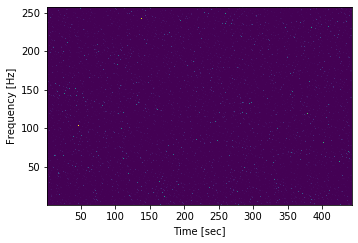

In [19]:
# calculate features

# show dimensions
print (np.shape(data)) # frequency bins, time bins, angle, file number, speaker, channel


# visualize features
plt.figure(figsize=(12, 8))
plt.subplot (221)
t = np.linspace(1,fftWindowT, fftWindowT)
f = np.linspace(1,fftWindowN, fftWindowN)
plot_data = data[:,:,0,0,0,0] # :,:,0,0,0,0
plot_data = plot_data / np.amax(np.amax(plot_data))
plt.pcolormesh(t, f, plot_data)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# prepare features for neural network
X = np.reshape(data, (fftWindowN, fftWindowT, angleN * filesN * speakerTypeN, micN))
X = np.moveaxis(X, (0,1,2,3), (1,2,0,3))

# get meta data
deg = np.linspace(0, 359, angleN)
deg = np.matlib.repmat(deg, 1, filesN  * speakerTypeN).transpose()
dist = np.full((filesN * angleN * speakerTypeN, 1), 1)

# prepare lables for neural network
#Y = np.vstack((deg.T, dist.T)).T
Y = deg
print (np.shape(Y)) # speaker-angle-file number, angle, distance
print (np.shape(X)) # speaker-angle-file number, frequency bins, time bins, channel


In [20]:
X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size = 0.2, random_state = 2)
print (np.shape(X_train))
print (np.shape(X_validate))
print (np.shape(Y_train))
print (np.shape(Y_validate))

(7244, 257, 443, 2)
(1812, 257, 443, 2)
(7244, 1)
(1812, 1)


In [22]:
# Define batchsize and number of epochs
batchSize = 20
nEpochs = 20


# Declare the sequential model and design your multi-layer perceptron
model = models.Sequential()

model.add(Conv2D(8, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Reshape((16,1408)))
model.add(Bidirectional(GRU(32)))

#model.add(Bidirectional(GRU(64)))

#model.add(Flatten())
model.add(Dense(256))
model.add(Activation('linear'))
model.add(Dense(64))
model.add(Activation('linear'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile your model
model.compile(loss='mean_absolute_error',
              optimizer='sgd',
              metrics=['mae','mse'])

X_train = X_train.astype('float16')
X_validate = X_validate.astype('float16')
Y_train = Y_train.astype('float16')
Y_validate = Y_validate.astype('float16')

# Train your model
model.fit(X_train, Y_train[:,0], epochs = nEpochs , batch_size = batchSize)


Epoch 1/20
9882/9882 [==============================] - 237s 24ms/step - loss: 0.1740 - mae: 0.1740 - mse: 0.0437
Epoch 2/20
9882/9882 [==============================] - 234s 24ms/step - loss: 0.1126 - mae: 0.1126 - mse: 0.0214
Epoch 3/20
9882/9882 [==============================] - 231s 23ms/step - loss: 0.0785 - mae: 0.0785 - mse: 0.0113
Epoch 4/20
9882/9882 [==============================] - 231s 23ms/step - loss: 0.0701 - mae: 0.0701 - mse: 0.0093
Epoch 5/20
9882/9882 [==============================] - 226s 23ms/step - loss: 0.0648 - mae: 0.0648 - mse: 0.0079
Epoch 6/20
9882/9882 [==============================] - 230s 23ms/step - loss: 0.0619 - mae: 0.0619 - mse: 0.0074
Epoch 7/20
9882/9882 [==============================] - 234s 24ms/step - loss: 0.0599 - mae: 0.0599 - mse: 0.0069
Epoch 8/20
9882/9882 [==============================] - 229s 23ms/step - loss: 0.0585 - mae: 0.0585 - mse: 0.0066
Epoch 9/20
9882/9882 [==============================] - 232s 24ms/step - loss: 0.0563 - 

In [23]:
model.build()
model.summary ()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 129, 358, 8)       296       
_________________________________________________________________
activation_12 (Activation)   (None, 129, 358, 8)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 129, 358, 8)       32        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 179, 8)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 179, 16)       1168      
_________________________________________________________________
activation_13 (Activation)   (None, 64, 179, 16)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 179, 16)      

In [24]:
model.evaluate (X_validate,Y_validate[:,0])

2471/2471 [==============================] - 18s 7ms/step


[0.064524416203069, 0.06452440470457077, 0.007977190427482128]

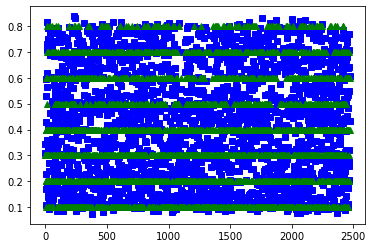

In [26]:
Y_pred = model.predict (X_validate)
index = 0
plt.plot (Y_pred[:,0],'bs',Y_validate[:,0],'g^')
plt.show()

In [ ]:
print (np.shape(Y_train))

In [ ]:
print (np.average(audioCh1Data[700:800]))

In [ ]:
np.save ('X.npy',X)
np.save ('Y.npy',Y)

In [15]:
model.save('angelGood.h5')